In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

In [4]:
# Configuration Settings
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
epochs = 30
batch_sizes = [100, 250, 500, 5000, 10000]

In [5]:
# Data Loader Function
def load_data(train_batch_size, test_batch_size):
    _transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=_transform),
        batch_size=train_batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=_transform),
        batch_size=test_batch_size, shuffle=True, num_workers=2)
    return train_loader, test_loader

In [6]:
# CNN Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# Sensitivity Calculation
def sensitivity(model):
    fNormAll = 0.0
    counter = 0
    for p in model.parameters():
        if p.grad is not None:
            fNorm = torch.linalg.norm(p.grad)
            fNormAll += fNorm.item()
            counter += 1
    return 0 if counter == 0 else fNormAll / counter

In [8]:

# Define Optimizer
def define_optimizer(model, lr=0.01):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

# Training and Evaluation
def train_and_evaluate(model, optimizer, train_loader, test_loader, loss_fn):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
    
    # Evaluate
    tr_loss, tr_acc = calculate_loss(model, train_loader, loss_fn)
    t_loss, t_acc = calculate_loss(model, test_loader, loss_fn)
    
    return tr_loss, t_loss, tr_acc, t_acc, sensitivity(model)

In [9]:
# Loss and Accuracy Calculation
def calculate_loss(model, loader, loss_fn):
    model.eval()
    correct, total, costTotal, costCounter = 0, 0, 0, 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            cost = loss_fn(output, target)
            costTotal += cost.item()
            costCounter += 1
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    return costTotal / costCounter, correct / total

In [10]:

# Plotting Function
def plot_results(batch_sizes, loss_train, loss_test, train_acc, test_acc, sensitivity):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(batch_sizes, loss_train, 'r-', batch_sizes, loss_test, 'g-')
    plt.title('Model Loss Comparison')
    plt.xlabel('Batch Size')
    plt.ylabel('Loss')
    plt.legend(['Train Loss', 'Test Loss'])

    plt.subplot(1, 2, 2)
    plt.plot(batch_sizes, train_acc, 'r--', batch_sizes, test_acc, 'g--')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Batch Size')
    plt.ylabel('Accuracy')
    plt.legend(['Train Accuracy', 'Test Accuracy'])
    plt.tight_layout()
    plt.show()


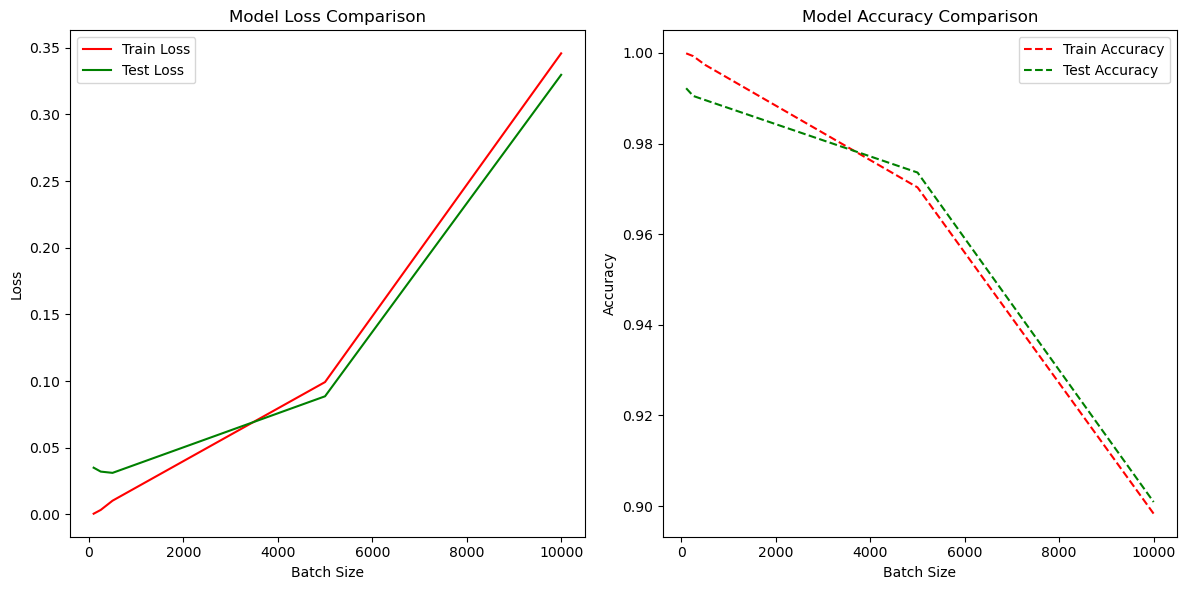

In [11]:
def main():
    loss_fn = torch.nn.CrossEntropyLoss()
    loss_train, loss_test, train_acc, test_acc, sens_list = [], [], [], [], []

    for batch in batch_sizes:
        train_loader, test_loader = load_data(batch, batch)
        model = CNN()
        optimizer = define_optimizer(model)
        tr_loss, t_loss, tr_acc, t_acc, sens = train_and_evaluate(model, optimizer, train_loader, test_loader, loss_fn)
        loss_train.append(tr_loss)
        loss_test.append(t_loss)
        train_acc.append(tr_acc)
        test_acc.append(t_acc)
        sens_list.append(sens)
    
    plot_results(batch_sizes, loss_train, loss_test, train_acc, test_acc, sens_list)

if __name__ == "__main__":
    main()